### Step.1 환경 설정 및 라이브러리 import

In [2]:
import os
import json
import random
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

### Step.2 데이터 불러오기 및 전처리 과정

In [3]:
#학습용 데이터 불러오기

train_csv = './DeepPCB_split/trainval_label.csv'
df = pd.read_csv(train_csv)
train_image_dir = './DeepPCB_split/train'

#filepath -> csv 파일의 filename 열에 저장되어 있는 이미지 이름과 동일한 이미지의 실제 경로(폴더)를 filepath에 저장
#예를 들어, filename -> file1.jpg 이면서 train_image_dir이 './train_images'라면 './train_images/file1.jpg 형태로 저장된다
df['filepath'] = df['filename'].apply(lambda x: os.path.join(train_image_dir, x))
'''
| filename  | filepath                  |
| --------- | ------------------------- |
| file1.jpg | ./train\_images/file1.jpg |
| file2.jpg | ./train\_images/file2.jpg |
| file3.jpg | ./train\_images/file3.jpg |
'''
#model 학습에 사용하기 위해 각각의 열을 list화
#filepaths: 이미지 파일의 경로 리스트
#labels: 'Defect' 열을 기반으로 한 정답 라벨 리스트(정상은 0, 불량은 1로 구성)
filepaths = df['filepath'].tolist()
labels = df['Defects'].tolist()

#테스트용 데이터 불러오기
test_csv = './DeepPCB_split/test_label.csv'
test_df = pd.read_csv(test_csv)
test_dir = './DeepPCB_split/test'

test_df['filepath'] = test_df['filename'].apply(lambda x: os.path.join(test_dir, x))

test_filepaths = test_df['filepath'].tolist()
test_labels = test_df['Defects'].tolist()


IMG_SIZE = 224  # CNN에서 보통 사용하는 표준 크기
BATCH_SIZE = 32 # 한 번의 모델 가중치 업데이트에 사용되는 개수

#decode_img: 이미지 경로 -> 실제 이미지 tensor로 변환하는 전처리 함수
#위 함수를 tf.data.Dataset에 연결해서 학습에 쓸 최종 데이터를 만든다.
def decode_img(img_path, label):  
    # 이미지 경로로 읽기
    img = tf.io.read_file(img_path)
    # JPEG 디코딩, 흑백 이미지이므로 channels = 1
    img = tf.image.decode_jpeg(img, channels=1)
    #명시적 형 변환(float 32)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 이미지 크기 재지정
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img, label

### Step.3 학습 데이터셋 구성(학습 / 검증 / 테스트)

In [5]:
#리스트 분할(80% 학습, 20% 검증)
train_files, val_files, train_labels, val_labels = train_test_split(
    filepaths, labels, test_size=0.2, random_state=42, stratify=labels
)

#Dataset 만들기
#학습용 Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_dataset = train_dataset.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
#검증용 Dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
val_dataset = val_dataset.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
#테스트용 Dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_filepaths, test_labels))
test_dataset = test_dataset.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Step.4 모델 정의 및 학습 & 시각화
1. 4단계의 Conv2D + MaxPooling2D 블록 및 softmax + sparse categorical crossentropy 손실 함수가 결합된 일반적인 CNN 모델(정상, 불량 클래스에 대한 각각의 확률값을 반환)
2. 1번 모델과 같은 블록이지만 sigmoid + binary_crossentropy 손실 함수 및 과적합 방지 코드로 결합합된 CNN 모델(불량률에 대한 확률값만 반환되어 이진 분류에 좀 더 적합한 모델)
3. 2번 모델을 기반으로 BatchMormalization + Dropout 레이어를 추가하여 좀 더 안정화된 CNN 모델
4. 네트워크가 깊어질수록 발생할 수 있는 정보 손실과 기울기 소실 문제를 완화시킨 ResNet 기반의 CNN 모델
5. 정보의 흐름을 극대화하고, 특징의 재활용을 가능하게 하여 효율 및 성능을 향상시킨 DenseNet 기반의 CNN 모델


In [67]:
EPOCH = 30

#model_1 : softmax + sparse_categorical_crossentropy, 출력층 2개
model = models.Sequential([
    layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    
    layers.Conv2D(16, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')
])
model.summary()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#모델 학습
history_1 = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs = EPOCH
                    )

result = model.evaluate(test_dataset)
accuracy_type1 = result[1]

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_166 (Conv2D)         (None, 222, 222, 16)      160       
                                                                 
 max_pooling2d_137 (MaxPooli  (None, 111, 111, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_167 (Conv2D)         (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_138 (MaxPooli  (None, 54, 54, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_168 (Conv2D)         (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_139 (MaxPooli  (None, 26, 26, 64)     

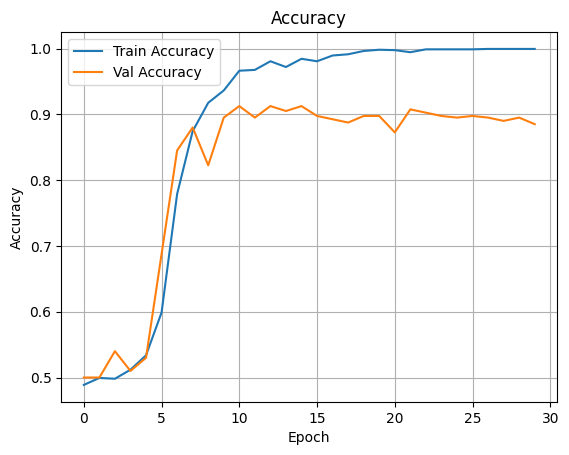

In [68]:
#Train Accuracy, Val Accuracy 비교
plt.plot(history_1.history['accuracy'], label='Train Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [69]:
EPOCH = 25 # 에폭의 수를 30 -> 25로 감소시킴

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

#콜백함수 지정
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

#model_2 : sigmoid + binary_crossentropy, 출력층 1개
model = models.Sequential([
    layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 1)),

    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


#모델 학습
history_2 = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs = EPOCH,
                    callbacks=[early_stop, reduce_lr]
                    )

result = model.evaluate(test_dataset)
accuracy_type2 = result[1]

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_170 (Conv2D)         (None, 222, 222, 16)      160       
                                                                 
 max_pooling2d_141 (MaxPooli  (None, 111, 111, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_171 (Conv2D)         (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_142 (MaxPooli  (None, 54, 54, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_172 (Conv2D)         (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_143 (MaxPooli  (None, 26, 26, 64)     

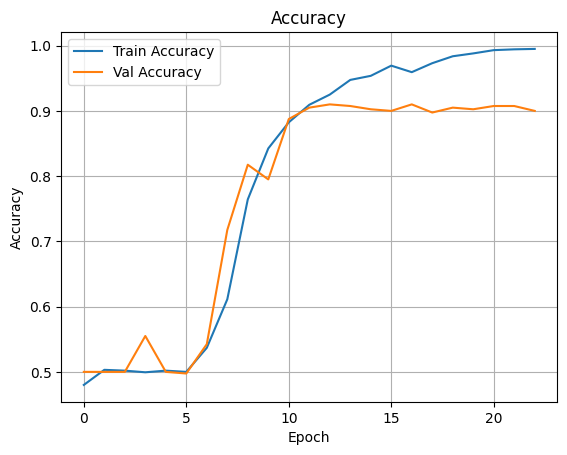

In [70]:
#Train Accuracy, Val Accuracy 비교
plt.plot(history_2.history['accuracy'], label='Train Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [73]:
#model_3 : Data Augmentation을 이용한 학습법

#콜백 함수 조정(factor 0.5 -> 0.3 조정)

early_stop = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0005, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6, verbose=1)

EPOCH = 20 #에폭의 수를 25 -> 20으로 감소시킴 

#data augmentation layer 정의(다양성을 증가시켜 과적합 방지 및 성능 증가 기대)
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.02),      # ±5도 회전 (구조 뒤틀림 방지)
    layers.RandomZoom(0.03),          # ±5% 줌 (모서리 정보 손실 방지)
    layers.RandomContrast(0.02),      # 대비 거의 유지 (원본이 고대비)
    layers.RandomTranslation(0.03, 0.03)  # ±5% 범위만 이동
])

def augment(image, label):
    image = data_augmentation(image)
    return image, label

augmented_train_dataset = train_dataset.map(augment)

model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1)),

    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])



model.summary()
model.compile(
    optimizer='Adam',  # 현재 1e-4였음 → 증가
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_3 = model.fit(
    augmented_train_dataset,
    validation_data=val_dataset,
    epochs=EPOCH,
    callbacks=[early_stop, reduce_lr]
)

result = model.evaluate(test_dataset)
accuracy_type3 = result[1]

Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_182 (Conv2D)         (None, 222, 222, 16)      160       
                                                                 
 max_pooling2d_153 (MaxPooli  (None, 111, 111, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_183 (Conv2D)         (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_154 (MaxPooli  (None, 54, 54, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_184 (Conv2D)         (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_155 (MaxPooli  (None, 26, 26, 64)     

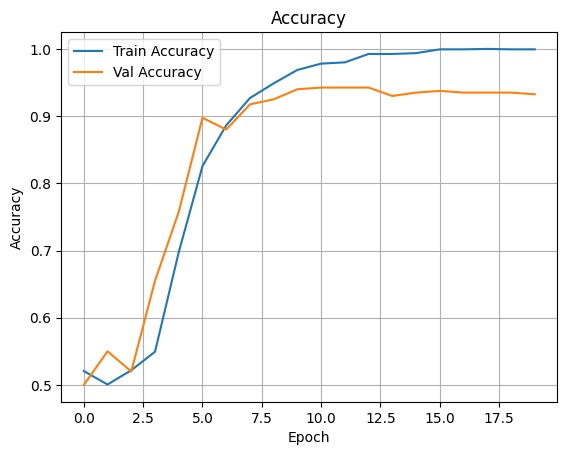

In [74]:
#Train Accuracy, Val Accuracy 비교
plt.plot(history_3.history['accuracy'], label='Train Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
#model_4 -> residual connections를 추가하여 정보 손실을 방지하는 모델
# 몇 개의 층을 건너뛰는 연결(shortcut = layers.Conv2D(filters, (1, 1), padding="same")(x)을 하나 만들어
# 다음 층들의 채널 수(filter)와 맞춰주어 덧셈연산이 가능하게 함
# 모델의 층이 깊어질 수록 정보가 소실되는 문제(기울기 소실, 과적합 등..)가 발생 할 수 있기에
# ADD 연산을 통해 입력이 그대로 다음 층으로 전달되고 층을 추가해도 성능이 나빠지지 않게 할 수 있음
def residual_block(x, filters):
    # shortcut 경로 : 입력 x 의 채널 수를 filters와 동일하게 맞춤
    shortcut = layers.Conv2D(filters, (1, 1), padding="same")(x)  # 크기 맞추기 

    # 주 경로 : 3x3 컨볼루션 두 번
    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    # shortcut과 주 경로를 더함
    x = layers.Add()([x, shortcut])  # 동일한 크기로 유지 
    x = layers.ReLU()(x)

    return x

# Model 4: ResNet 구조
input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
x = layers.Conv2D(64, (3,3), activation='relu', padding="same")(input_layer)
x = layers.BatchNormalization()(x)

x = residual_block(x, 64)
x = layers.MaxPooling2D()(x)

x = residual_block(x, 128)
x = layers.MaxPooling2D()(x)

x = residual_block(x, 256)
x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.6)(x)  # 드롭아웃 수치 (0.5 -> 0.6)
output_layer = layers.Dense(2, activation='softmax')(x)

model_4 = models.Model(inputs=input_layer, outputs=output_layer)
model_4.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

# 모델 학습
model_4.summary()
history_4 = model_4.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=EPOCH)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 224, 224, 64  640         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_14 (BatchN  (None, 224, 224, 64  256        ['conv2d_24[0][0]']              
 ormalization)                  )                                                           

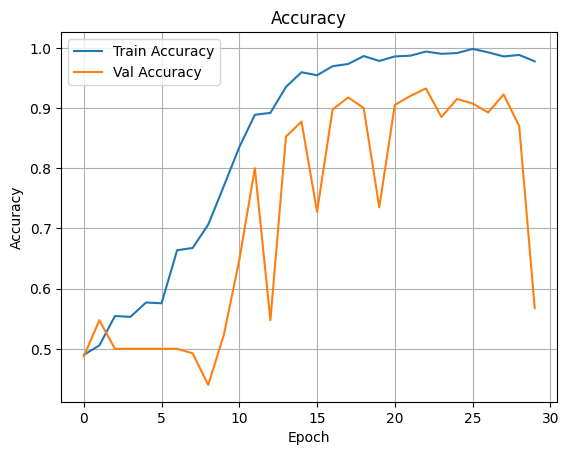

In [10]:
#Train Accuracy, Val Accuracy 비교
plt.plot(history_4.history['accuracy'], label='Train Accuracy')
plt.plot(history_4.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# model_5 -> dense connection 구조를 추가하여 정보 손실을 방지하는 모델
def dense_block(x, num_layers, growth_rate):
    for _ in range(num_layers):
        conv_layer = layers.Conv2D(growth_rate, (3, 3), padding='same', activation='relu')(x)
        conv_layer = layers.BatchNormalization()(conv_layer)
        x = layers.Concatenate()([x, conv_layer])  # Dense Connection 

    return x 

# Model 5: DenseNet 구조
input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
x = layers.Conv2D(16, (3,3), activation='relu', padding="same")(input_layer)
x = layers.BatchNormalization()(x)

x = dense_block(x, 2, 16)
x = layers.MaxPooling2D()(x)

x = dense_block(x, 2, 32)
x = layers.MaxPooling2D()(x)

x = dense_block(x, 2, 64)
x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(2, activation='softmax')(x)

model_5 = models.Model(inputs=input_layer, outputs=output_layer)
model_5.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

# 모델 학습
model_5.summary()
history_5 = model_5.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=EPOCH)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_37 (Conv2D)             (None, 224, 224, 16  160         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_21 (BatchN  (None, 224, 224, 16  64         ['conv2d_37[0][0]']              
 ormalization)                  )                                                           

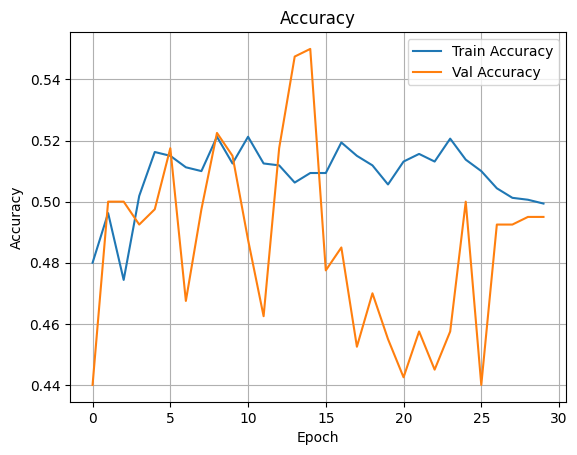

In [16]:
#Train Accuracy, Val Accuracy 비교
plt.plot(history_5.history['accuracy'], label='Train Accuracy')
plt.plot(history_5.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Step 6. 모델 성능 비교 및 시각화
* Step 5.를 통해 학습된 모델들을 테스트 데이터셋을 통해 평가하고 그 결과를 서로 비교하여 원하는 결과에 도달했는지를 검증

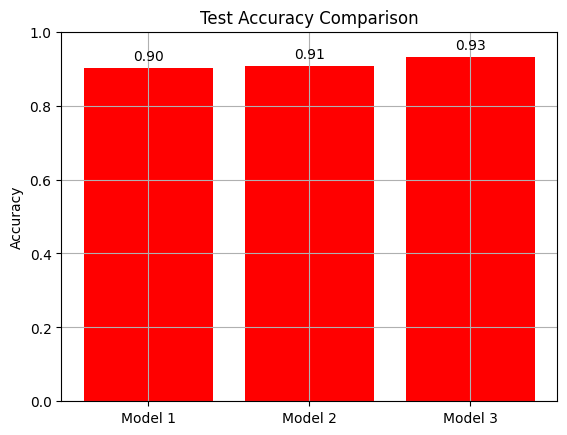

In [75]:


test_accs = [accuracy_type1, accuracy_type2, accuracy_type3] #test_acc4, test_acc5]
model_names = ["Model 1", "Model 2", "Model 3"]#, "Model 4", "Model 5"]

for i, acc in enumerate(test_accs):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center')

plt.bar(model_names, test_accs, color = "red")
plt.title("Test Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.show()